# Testing Stable Baselines3 with gym-MiniGrid

## Basic Jupyter Setting

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Setup the Colab environment (if used over Google Colab)

In [2]:
# @title Install dependencies
#!pip install rarfile --quiet
#!pip install stable-baselines3 > /dev/null
#!pip install box2d-py > /dev/null
#!pip install gym gym-minigrid pyvirtualdisplay > /dev/null 2>&1
#!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

## Import Stable-Baselines3 and initial set-up

Import libraries and classes:

In [30]:
# Imports
import time
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from random import randint 
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper

Define the video function:

In [5]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


Define the rendering wrappers:

In [6]:
from gym.wrappers import Monitor

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

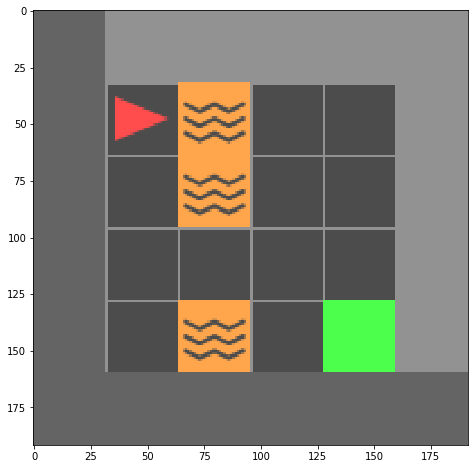

In [154]:
from random import randint
#env_id = 'MiniGrid-Empty-16x16-v0'
#env_id = 'MiniGrid-DoorKey-8x8-v0'
#env_id = 'MiniGrid-DistShift1-v0'
#env_id ='MiniGrid-UnlockPickup-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
env_id = 'MiniGrid-LavaGapS6-v0'

eval_env = gym.make(env_id)
eval_env.seed(10000+randint(0, 10))
eval_env.reset()
before_img = eval_env.render('rgb_array')

plt.imshow(before_img);

# Simple Curriculum Learning
Now we do some Curriculum Learning, and keep training the model with the second environment. Let's create the new vectorized environment:

In [ ]:
# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use
new_env_id = 'MiniGrid-DistShift2-v0'
vec_env = make_vec_env(new_env_id, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

Load the last saved trained model with the new environment:

In [ ]:
# previous saved environment
prev_env_id = env_id + '_2'

# load the model on previous vectorized env and tensorboard log directory
model = PPO.load(path=prev_env_id, env=vec_env, tensorboard_log=tensorboard_log)
#model.set_env(vec_env)

Continue the training, but over the new environment:

In [ ]:
# number of timesteps to add
total_timesteps = 500000
log_interval = 10

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=False, 
            callback=callback)

Logging to ./tmp/log/MiniGrid-DistShift1-v0_1
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 22.1       |
|    ep_rew_mean          | 0.921      |
| time/                   |            |
|    fps                  | 778        |
|    iterations           | 10         |
|    time_elapsed         | 52         |
|    total_timesteps      | 745472     |
| train/                  |            |
|    approx_kl            | 0.02460795 |
|    clip_fraction        | 0.151      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.247      |
|    learning_rate        | 5e-05      |
|    loss                 | -0.0128    |
|    n_updates            | 724        |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 0.0094     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_l

Let's save the model at this point:

In [ ]:
# Save the agent
new_env_id2 = 'MiniGrid-DistShift2_with_1-v0'
model.save(new_env_id2) 

We add some more few steps of training:

In [ ]:
# uncomment to load the last saved model in case the notebook kernel is restarted
#model = PPO.load(path=new_env_id2, env=vec_env, tensorboard_log=tensorboard_log)

# number of timesteps to add
total_timesteps = 500000
log_interval = 10

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=False, 
            callback=callback)

Logging to ./tmp/log/MiniGrid-DistShift1-v0_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 17.9        |
|    ep_rew_mean          | 0.936       |
| time/                   |             |
|    fps                  | 763         |
|    iterations           | 10          |
|    time_elapsed         | 53          |
|    total_timesteps      | 1249280     |
| train/                  |             |
|    approx_kl            | 0.038906373 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.118      |
|    explained_variance   | 0.852       |
|    learning_rate        | 5e-05       |
|    loss                 | -0.0115     |
|    n_updates            | 1216        |
|    policy_gradient_loss | 0.00679     |
|    value_loss           | 0.000273    |
-----------------------------------------
-----------------------------------------
| rollout/                |   

In [ ]:
# Save the agent
new_env_id3 = 'MiniGrid-DistShift2_with_1-v0_2'
model.save(new_env_id3) 

Let's try now the performance on the new environment 'MiniGrid-DistShift2-v0':

In [ ]:
# uncomment to load the last saved model in case the notebook kernel is restarted, etc.
model = PPO.load(path=new_env_id3)

# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make('MiniGrid-DistShift2-v0'))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9464285969734192 +/- 0.00


And now, let's try also with the first environment 'MiniGrid-DistShift1-v0' to see what happens:

In [ ]:
# uncomment to load the last saved model in case the notebook kernel is restarted, etc.
# model = PPO.load(path=new_env_id3)

# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make('MiniGrid-DistShift1-v0'))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9464285969734192 +/- 0.00


Let's run the predict over the two environments and see how it goes now. We first try with the latest environment training 'MiniGrid-DistShift2-v0', it does solve it thought through a longer path:

In [ ]:
model = PPO.load(path='MiniGrid-DistShift2_with_1-v0_2')

env_id = 'MiniGrid-DistShift2-v0'

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.9464285714285714
Total length: 15


And now with the first learned environment 'MiniGrid-DistShift1-v0', where it changed its behaviour making a slightly longer run also:

In [ ]:
env_id = 'MiniGrid-DistShift1-v0'

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.9464285714285714
Total length: 15


# Curriculum learning

## Define the environments and settings

In [ ]:
# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use
env_id_1 = 'MiniGrid-DoorKey-5x5-v0'
vec_env_1 = make_vec_env(env_id_1, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

env_id_2 = 'MiniGrid-DoorKey-6x6-v0'
vec_env_2 = make_vec_env(env_id_2, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

env_id_3 = 'MiniGrid-DoorKey-8x8-v0'
vec_env_3 = make_vec_env(env_id_3, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

env_id_4 = 'MiniGrid-DoorKey-16x16-v0'
vec_env_4 = make_vec_env(env_id_4, n_envs=num_cpu, wrapper_class=FlatObsWrapper)

In [ ]:
learning_rate = 0.00005
n_steps = 256
batch_size = 16
ent_coef = 0.001
n_epochs = 4

tensorboard_log = "./tmp/log/"
os.makedirs(tensorboard_log, exist_ok=True)

tb_log_name = 'Curriculum-Doorkey'

## Learn 1st lesson

In [ ]:
# Reset the environment
vec_env_1.reset()

# create the model
model = PPO('MlpPolicy',
            env=vec_env_1,
            learning_rate=learning_rate,
            batch_size=batch_size,
            ent_coef=ent_coef,
            n_epochs=n_epochs,
            n_steps=n_steps,
            tensorboard_log=tensorboard_log,
            verbose=1)

Using cpu device


In [ ]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create eval environment
env = gym.make(env_id_1)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();
# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.90, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

In [ ]:
total_timesteps = 500000
log_interval = 10

model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name = tb_log_name,
            callback=eval_callback)

Logging to ./tmp/log/Curriculum-Doorkey_1
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 222          |
|    ep_rew_mean          | 0.131        |
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 10           |
|    time_elapsed         | 50           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0062883142 |
|    clip_fraction        | 0.0204       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.8         |
|    explained_variance   | 0.4          |
|    learning_rate        | 5e-05        |
|    loss                 | 0.00072      |
|    n_updates            | 36           |
|    policy_gradient_loss | -0.00405     |
|    value_loss           | 0.00368      |
------------------------------------------
-----------------------------------------
| rollout/   

In [ ]:
# Save the agent
model.save(env_id_1)

In [ ]:
#model = PPO.load(path=env_id_1)

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_1))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9596799850463867 +/- 0.01


In [ ]:
env_id = env_id_1

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.9604
Total length: 11


## Learn 2nd lesson

In [ ]:
model.set_env(vec_env_2)

In [ ]:
# Create eval environment
env = gym.make(env_id_2)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();
# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.90, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

In [ ]:
# number of timesteps to add
total_timesteps = 1000000
log_interval = 10

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=False, 
            callback=eval_callback)

Logging to ./tmp/log/Curriculum-Doorkey_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 159         |
|    ep_rew_mean          | 0.573       |
| time/                   |             |
|    fps                  | 873         |
|    iterations           | 10          |
|    time_elapsed         | 46          |
|    total_timesteps      | 200960      |
| train/                  |             |
|    approx_kl            | 0.013858551 |
|    clip_fraction        | 0.0627      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.599      |
|    explained_variance   | 0.467       |
|    learning_rate        | 5e-05       |
|    loss                 | -0.0185     |
|    n_updates            | 192         |
|    policy_gradient_loss | -0.000816   |
|    value_loss           | 0.00367     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

In [ ]:
# Save the agent
model.save(env_id_2)

In [ ]:
model = PPO.load(path=env_id_2)

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_2))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9677500009536744 +/- 0.01


In [ ]:
env_id = env_id_2

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.965
Total length: 14


## Learn 3rd lesson

In [ ]:
model.set_env(vec_env_3)

# Create eval environment
env = gym.make(env_id_3)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();
# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.90, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

# number of timesteps to add
total_timesteps = 1000000
log_interval = 10

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=False, 
            callback=eval_callback)

Logging to ./tmp/log/Curriculum-Doorkey_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 295         |
|    ep_rew_mean          | 0.557       |
| time/                   |             |
|    fps                  | 865         |
|    iterations           | 10          |
|    time_elapsed         | 47          |
|    total_timesteps      | 360960      |
| train/                  |             |
|    approx_kl            | 0.012058819 |
|    clip_fraction        | 0.0997      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.433      |
|    explained_variance   | 0.124       |
|    learning_rate        | 5e-05       |
|    loss                 | -0.0632     |
|    n_updates            | 348         |
|    policy_gradient_loss | 0.00335     |
|    value_loss           | 0.00184     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

In [ ]:
# Save the agent
model.save(env_id_3)

In [ ]:
model = PPO.load(path=env_id_3)

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_3))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9706093847751618 +/- 0.01


In [ ]:
env_id = env_id_3

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.96625
Total length: 24


## Learn 4th lesson

In [ ]:
model.set_env(vec_env_4)

# Create eval environment
env = gym.make(env_id_4)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();
# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.90, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

# number of timesteps to add
total_timesteps = 1000000
log_interval = 10

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=False, 
            callback=eval_callback)

Logging to ./tmp/log/Curriculum-Doorkey_1
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 347          |
|    ep_rew_mean          | 0.874        |
| time/                   |              |
|    fps                  | 828          |
|    iterations           | 10           |
|    time_elapsed         | 49           |
|    total_timesteps      | 520960       |
| train/                  |              |
|    approx_kl            | 0.0130156595 |
|    clip_fraction        | 0.104        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.342       |
|    explained_variance   | 0.358        |
|    learning_rate        | 5e-05        |
|    loss                 | -0.00808     |
|    n_updates            | 504          |
|    policy_gradient_loss | -0.00154     |
|    value_loss           | 0.00304      |
------------------------------------------
-----------------------------------------
| rollout/   

In [ ]:
# Save the agent
model.save(env_id_4)

In [ ]:
model = PPO.load(path=env_id_4)

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_4))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.7346542984247207 +/- 0.42


In [ ]:
env_id = env_id_4

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.9841796875
Total length: 45


## Learn 4th lesson directly with no curriculum

In [ ]:
# Reset the environment
vec_env_4.reset()

# create the model
model = PPO('MlpPolicy',
            env=vec_env_4,
            learning_rate=learning_rate,
            batch_size=batch_size,
            ent_coef=ent_coef,
            n_epochs=n_epochs,
            n_steps=n_steps,
            tensorboard_log=tensorboard_log,
            verbose=1)

Using cpu device


In [ ]:
# Create eval environment
env = gym.make(env_id_4)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();
# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.90, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

# number of timesteps to add
total_timesteps = 1000000
log_interval = 10
tb_log_name = 'Doorkey-16x16'

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name = tb_log_name)

Logging to ./tmp/log/Doorkey-16x16_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.56e+03    |
|    ep_rew_mean          | 0           |
| time/                   |             |
|    fps                  | 789         |
|    iterations           | 10          |
|    time_elapsed         | 51          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.005105094 |
|    clip_fraction        | 0.00696     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.92       |
|    explained_variance   | -2.82       |
|    learning_rate        | 5e-05       |
|    loss                 | -0.0163     |
|    n_updates            | 36          |
|    policy_gradient_loss | -0.00385    |
|    value_loss           | 0.000182    |
-----------------------------------------
-----------------------------------------
| rollout/                |            

In [ ]:
# Save the agent
model.save('MiniGrid-DoorKey-16x16-v0_no_curr')

In [ ]:
env_id = 'MiniGrid-DoorKey-16x16-v0_no_curr'
model = PPO.load(path=env_id)

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_4))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.0 +/- 0.00


In [ ]:
env_id = env_id_4

test_env = gen_wrapped_env(env_id)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0
Total length: 2560


## Quick Test Catastrophic Forgetting

Let's load the final curriculum learned model after lesson 4, and run prediction back to lesson 1 and lesson 2 to see how it performs:

In [ ]:
model = PPO.load(path=env_id_4)

Now we evaluate this trained model over lesson 1. There is a clear reduction in performance in comparison with initial mean_reward right after training over lesson 1:

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_1))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.5208479928970337 +/- 0.48


We evaluate as well over lesson 2. Also some perfomance decrease, but not as strong as with lesson 1:

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_2))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.8295999944210053 +/- 0.33


Over lesson 3:

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_3))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9494843816757202 +/- 0.14


Over lesson 4 (we had this one already):

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_4))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.7447281229496002 +/- 0.42


# Catastrophic Forgetting

## Define the environments

In [149]:
# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use

env_id_1 = 'MiniGrid-DoorKey-6x6-v0'
vec_env_1 = make_vec_env(env_id_1, n_envs=num_cpu, wrapper_class=FlatObsWrapper, seed=10000)

env_id_2 = 'MiniGrid-LavaGapS6-v0'
vec_env_2 = make_vec_env(env_id_2, n_envs=num_cpu, wrapper_class=FlatObsWrapper, seed=5000)

env_id_3 = 'MiniGrid-RedBlueDoors-6x6-v0'
vec_env_3 = make_vec_env(env_id_3, n_envs=num_cpu, wrapper_class=FlatObsWrapper, seed=20000)

In [12]:
learning_rate = 0.00005
n_steps = 256
batch_size = 16
ent_coef = 0.001
n_epochs = 4

tensorboard_log = "./tmp/log/"
os.makedirs(tensorboard_log, exist_ok=True)

## Learn first environment:

In [13]:
# Reset the environment
vec_env_1.reset()

# create the model
model = PPO('MlpPolicy',
            env=vec_env_1,
            learning_rate=learning_rate,
            batch_size=batch_size,
            ent_coef=ent_coef,
            n_epochs=n_epochs,
            n_steps=n_steps,
            tensorboard_log=tensorboard_log,
            verbose=1)

Using cpu device


In [14]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create eval environment
env = gym.make(env_id_1)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();

# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.92, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

In [15]:
total_timesteps = 1000000
log_interval = 10

tb_log_name = 'task01-doorkey-6x6'

model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name = tb_log_name,
            callback=eval_callback)

Logging to ./tmp/log/task01-doorkey-8x8_1
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 358          |
|    ep_rew_mean          | 0.00717      |
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 10           |
|    time_elapsed         | 50           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0049092257 |
|    clip_fraction        | 0.0157       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.9         |
|    explained_variance   | -1.84        |
|    learning_rate        | 5e-05        |
|    loss                 | -0.00569     |
|    n_updates            | 36           |
|    policy_gradient_loss | -0.00168     |
|    value_loss           | 0.000105     |
------------------------------------------
-----------------------------------------
| rollout/   

In [94]:

tb_log_name = 'task01-doorkey-6x6'
print(tb_log_name)

task01-doorkey-6x6


In [19]:
# Save the agent
model.save(tb_log_name)

In [ ]:
#model = PPO.load(path=tb_log_name)

In [93]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_1))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.9121249884366989 +/- 0.21


In [150]:
env_id = env_id_1
test_env = gen_wrapped_env(env_id)
# generate a random initialization for the environment

test_env.seed(randint(1, num_cpu))
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.9525
Total length: 19


## Learn second environment

In [151]:
model.set_env(vec_env_2)

In [152]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create eval environment
env = gym.make(env_id_2)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();

# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.92, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

In [153]:
# number of timesteps to add
total_timesteps = 2000000
log_interval = 10
tb_log_name = 'task02-lava'

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=True,
            callback=eval_callback)

Logging to ./tmp/log/task02-lava_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.04        |
|    ep_rew_mean          | 0.22        |
| time/                   |             |
|    fps                  | 776         |
|    iterations           | 10          |
|    time_elapsed         | 52          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.003279253 |
|    clip_fraction        | 0.0492      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.341      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5e-05       |
|    loss                 | 0.00179     |
|    n_updates            | 504         |
|    policy_gradient_loss | -0.0016     |
|    value_loss           | 0.000308    |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|

In [155]:
print(tb_log_name)

task02-lava


In [156]:
# Save the agent
model.save(tb_log_name)

In [ ]:
#model = PPO.load(path=tb_log_name)

In [179]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_2))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.2868750035762787 +/- 0.44


In [175]:
test_env = gen_wrapped_env(env_id_2)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0.725
Total length: 44


In [182]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_1))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Mean reward: 0.0 +/- 0.00


In [186]:
test_env = gen_wrapped_env(env_id_1)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

Total reward: 0
Total length: 360
